In [277]:
import numpy as np
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('punkt')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1) Create the functions that are in charge of preprocessing strings. NLP tools implemented in functions that will help us prepare training data.

In [93]:
#function to tokenize a string sentence
def tokenize(sentence):
  return nltk.word_tokenize(sentence)

In [94]:
#function to stem words...lower case then stem
stemmer = PorterStemmer()
def stem(word):
  return stemmer.stem(word.lower())

In [95]:
# Function takes in the tokenized sentence and all words in a json file, returns an array of 0 (word absent) or 1 (word present) representing the all words array.
def bag_of_words(tokenized_sentence, all_words):
  tokenized_sentence = [stem(w) for w in tokenized_sentence]
  bag = np.zeros(len(all_words),dtype = np.float32)
  for index, w in enumerate(all_words): #loop over all words list
    if w in tokenized_sentence: #if the word in all words list, is in tokenized sentence list
      bag[index] = 1.0 #then turn on a 1 in the relevant position in the all words numpy list called bag.
  return bag

In [96]:
#An example of how the functions work
sentence_ex = "Hello how are you?"

token_sentence = tokenize(sentence_ex)
print(token_sentence)

words_reference = ['hi','hello','I','you','bye','thank','cool']
print(words_reference)
bag = bag_of_words(token_sentence,words_reference)
print(bag)

['Hello', 'how', 'are', 'you', '?']
['hi', 'hello', 'I', 'you', 'bye', 'thank', 'cool']
[0. 1. 0. 1. 0. 0. 0.]


In [97]:
#An example of how stemming works
words = ['organize', 'organizes','organizing']
stemmed_words = [stem(w) for w in words]
print(stemmed_words)

['organ', 'organ', 'organ']


## 2) Read in json file of intents that serves as a dictionary of words to create training data. Later, we will be using this file for many reasons: creating all_words array, querying it to match a user input to respond to the user, and more!



In [98]:
import json

In [99]:
#open the json file in reading mode and name it intents
with open('intents.json','r') as file:
  intents = json.load(file)

In [100]:
#create empty lists that we will be appending to in order to prepare our training data
all_words = []
all_tags = []
words_and_tag = []

#### The json intents file: a file containing the dictionary of patterns and responses categorized under different tags. So each tag (greeting) has a pattern (hi, hello,...) and a response (hi there, hello back,...)

#### This json file: one big dictionary containg ONE main key ("intents":) and ONE main corresponding value which is a LIST. This list contains another dictionary which have keys: "tag": string value, "patterns": list of strings value, and "responses": list of strings value.

In [101]:
for intent in intents['intents']: #access json dictionary main key intents, gives acces to the one and only LIST that has the other dictionaries!
  tag = intent['tag'] #once in the value of main key "intents", access the "tag" key and append it
  all_tags.append(tag)
  for pattern in intent['patterns']:  #now that we are inside the first dictionary in the main list, we INNER loop that dictionary
    words = tokenize(pattern)
    all_words.extend(words) #EXTEND, not append because tokenize takes a string and returns an array/list, if we do append, all_words would be a list of lists
    words_and_tag.append((words,tag)) #pair up each tokenized sentence entry with its relevant tag

ignore_list = ['?','!','.',',']
all_words = [stem(w) for w in all_words if w not in ignore_list] # a good way to loop over a list and perform a function on each entry
all_words = sorted(set(all_words))
all_tags = sorted(set(all_tags)) 

In [102]:
#Lets take a look at words and tag
print(words_and_tag)
print(all_tags)

[(['Hey'], 'greeting'), (['Hi'], 'greeting'), (['How', 'are', 'you'], 'greeting'), (['anyone', 'there', '?'], 'greeting'), (['Hello'], 'greeting'), (['hello', 'there'], 'greeting'), (['Good', 'day'], 'greeting'), (['Bye'], 'goodbye'), (['See', 'you', 'later'], 'goodbye'), (['thank', 'you', ',', 'good', 'bye'], 'goodbye'), (['Goodbye', ',', 'have', 'a', 'good', 'one'], 'goodbye'), (['Thank', 'you'], 'thanks'), (['Thanks'], 'thanks'), (['Thanks', 'for', 'the', 'help'], 'thanks'), (['Thanks', 'a', 'lot', '!'], 'thanks'), (['Which', 'products', 'do', 'you', 'have', '?'], 'products'), (['What', 'kind', 'of', 'products', '?'], 'products'), (['What', 'do', 'you', 'sell', '?'], 'products'), (['what', 'products', 'do', 'you', 'offer'], 'products'), (['Can', 'I', 'pay', 'with', 'Paypal', '?'], 'payments'), (['Do', 'you', 'take', 'credit', 'cards', '?'], 'payments'), (['Do', 'you', 'accept', 'Mastercard', '?'], 'payments'), (['Are', 'you', 'cash', 'only', '?'], 'payments'), (['How', 'can', 'I', '

#### At this point we have distinct, sorted lists of tokenized and stemmed words and corresponding tags, read in from our json file. Time to loop over the words_and_tag tuple we made earlier and append each tokenized & stemmed sentence after bagging it to get an encoded all_words array as a feature and its relvant tag as a label.

## 3) Creating our x_traing and y_train sets

In [250]:
#creating our x_train and y_train data
X = []
Y = []
for (pattern_sentence,tag) in words_and_tag:
  bag = bag_of_words(pattern_sentence, all_words)
  X.append(bag)

  label = all_tags.index(tag) #we assign the index numerical value of the label to the relevant x value (bag of words array)
  Y.append(label)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train = np.array(X_train)
y_train = np.array(Y_train)
x_test = np.array(X_test)
y_test = np.array(Y_test)

### Created a class called ChatDataset that we will use to help us with loading in and training out data

In [189]:
class ChatDataset(Dataset):
  def __init__(self):
    self.n_samples = len(x_train)
    self.x_data = x_train
    self.y_data = y_train
  
  #so we are able to go through data set index
  def __getitem__(self,index):
    return self.x_data[index], self.y_data[index]
  
  def __len__(self):
    return self.n_samples

In [190]:
#Hyperparameters
batch_size = 8
hidden_size = 8
input_size = len(x_train[0]) #length of bag of words which is length of all_words which is one iterable in x_train
output_size = len(all_tags)
learning_rate = 0.001
epochs = 500

In [191]:
#calling our class object that we made and assigning it to variable dataset and
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size = batch_size, shuffle = True, num_workers=2)

## 4) Create our feed forward neural network model consiting of three linear layers! (Input layer: number of different patterns,a hidden layer, and an output layer: of the number of possible labels. Relu activation between each layer except after the last one!

In [192]:
class NeuralNet(nn.Module):
  def __init__(self,input_size,hidden_size,num_classes):
    super(NeuralNet,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,num_classes)
    self.relu = nn.ReLU()

  def forward(self,x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out) #dont do classification activation (softmax) here because will be applied crossentropyloss later.
    return out

In [193]:
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 model = NeuralNet(input_size,hidden_size,output_size).to(device)

In [194]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [264]:
loss_list = []
for epoch in range(epochs):
  for (words, labels) in train_loader:
    words = words.to(device)
    labels = labels.to(device)

    #forward
    outputs = model(words)
    loss = criterion(outputs, labels)

    #backward and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  if (epoch + 1) % 10 ==0:
    print(f'epoch {epoch+1}/{epochs}, loss = {loss.item():.4f}')
    loss_list.append(loss.item())
  
print(f'final loss, loss = {loss.item():.4f}')

epoch 10/500, loss = 0.0038
epoch 20/500, loss = 0.0026
epoch 30/500, loss = 0.0026
epoch 40/500, loss = 0.0054
epoch 50/500, loss = 0.0023
epoch 60/500, loss = 0.0034
epoch 70/500, loss = 0.0009
epoch 80/500, loss = 0.0034
epoch 90/500, loss = 0.0014
epoch 100/500, loss = 0.0033
epoch 110/500, loss = 0.0030
epoch 120/500, loss = 0.0032
epoch 130/500, loss = 0.0020
epoch 140/500, loss = 0.0031
epoch 150/500, loss = 0.0025
epoch 160/500, loss = 0.0015
epoch 170/500, loss = 0.0016
epoch 180/500, loss = 0.0018
epoch 190/500, loss = 0.0012
epoch 200/500, loss = 0.0011
epoch 210/500, loss = 0.0015
epoch 220/500, loss = 0.0013
epoch 230/500, loss = 0.0018
epoch 240/500, loss = 0.0019
epoch 250/500, loss = 0.0018
epoch 260/500, loss = 0.0007
epoch 270/500, loss = 0.0015
epoch 280/500, loss = 0.0008
epoch 290/500, loss = 0.0004
epoch 300/500, loss = 0.0009
epoch 310/500, loss = 0.0008
epoch 320/500, loss = 0.0007
epoch 330/500, loss = 0.0009
epoch 340/500, loss = 0.0015
epoch 350/500, loss = 0

### Lets take a look at our training loss with time during model training. Gradual decrease with time indicating model error decreases as it trains more and more!

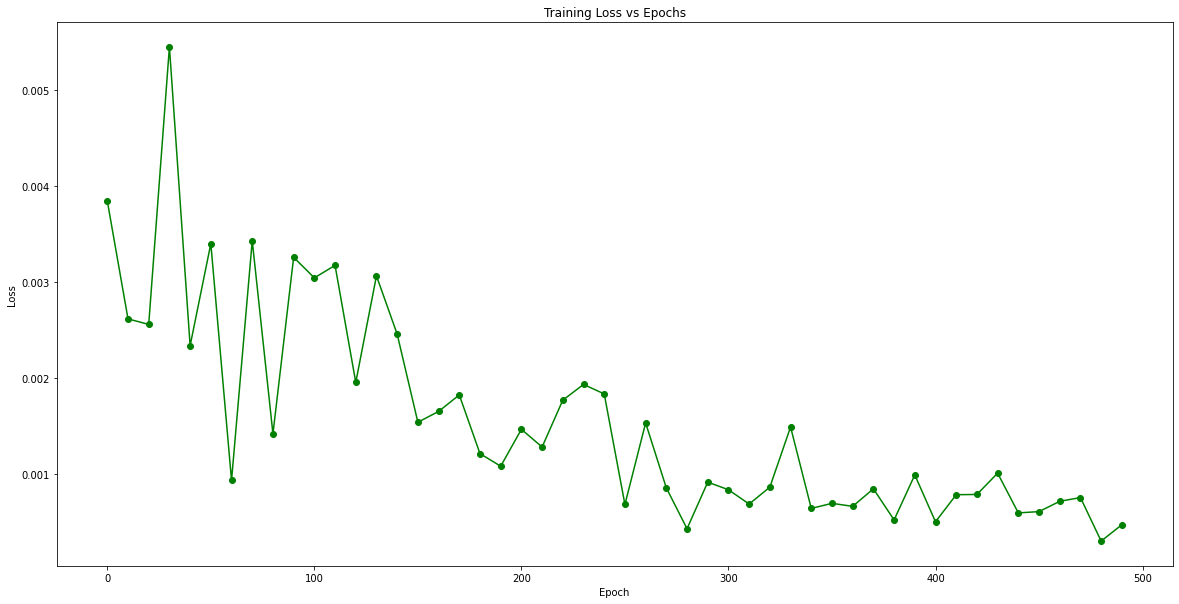

In [265]:
plt.figure(figsize=(20,10))
plt.plot(list(range(0,500,10)),loss_list, color='green',marker = 'o')
plt.ylabel('Loss')
plt.xlabel("Epoch")
plt.title("Training Loss vs Epochs")
plt.show()

In [266]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "output_size": output_size,
    "hidden_size": hidden_size,
    "all_words": all_words,
    "tags": all_tags
}

### If we were working with multiple .py files and want to utilize our model elsewhere, this is how you would save it! But we dont need it since we are using the handy dandy Jupyter.

In [283]:
FILE = "data.pth" #serialize file and save to a pickeled file
torch.save(data,FILE) #dont think I need this step.  

## 5) Lets Look at our model metrics!

In [282]:
test_data = torch.from_numpy(x_test)
output = model(test_data)
_, predicted = torch.max(output, 1)
y_pred = predicted.numpy()
y_test

print(f"On our testing data, we get an accuracy score of {accuracy_score(y_test,y_pred)*100:.2f}%")
print(f"On our testing data, we get an f1 score of {f1_score(y_test,y_pred,average='weighted'):.2f}")

On our testing data, we get an accuracy score of 83.33%
On our testing data, we get an f1 score of 0.83


#### Note that our metric reliability would be improved if we had a much larger data set, since I wrote the json file by hand, the number of training examples may be limited. This is, however, a good representation of the model performing very well in addition to the decreasing training loss above.

## Final step is to implement the chatbot

In [217]:
model.load_state_dict(data['model_state'])
model.eval()

NeuralNet(
  (l1): Linear(in_features=52, out_features=8, bias=True)
  (l2): Linear(in_features=8, out_features=8, bias=True)
  (l3): Linear(in_features=8, out_features=6, bias=True)
  (relu): ReLU()
)

#### I decide to create a bunch of potential bot names so that they are randomized everytime the program is run. This is to simulate the feeling of having the customer feel like they are talking to actual employees. I feel like it is more sentimental to the customer.

In [218]:
bot_names = ["Randy","Samantha","Joe","Bella"]
bot_name = random.choice(bot_names)


In [290]:
#The main loop that prompts the user, and interacts with them.
print("Hello, how can I help? (type 'quit' to exit)")

while True:
   sentence = input("You: ")
   if sentence == "quit":
     break

   sentence = tokenize(sentence)
   x = bag_of_words(sentence, all_words)
   x = x.reshape(1,x.shape[0]) #our model expects this shape
   x = torch.from_numpy(x) #convert to a torch tensor

   output = model(x)
   _, predicted = torch.max(output,dim=1)
   tag = all_tags[predicted.item()]

   
   prob = torch.softmax(output,dim=1)
   prob_actual = prob[0][predicted.item()]

   if prob_actual.item() > 0.75:
     for intent in intents['intents']:
       if tag == intent['tag']:
         print(f"{bot_name}: {random.choice(intent['responses'])}")
   else:
     print(f"{bot_name}: I do not understand, can you reiterate?")

Hello, how can I help? (type 'quit' to exit)
You: Hello
Bella: Hi there, what can I do for you?
You: What products do you guys have?
Bella: We sell fitness products
You: Do you take cash?
Bella: We accept VISA, Mastercard and Paypal
You: How long does shipping need?
Bella: Shipping takes 2-4 business days
You: thanks!
Bella: No worries
You: Remind me of your products?
Bella: Anything fitness related, we got it!
You: goodbye!
Bella: Have a great day
You: quit
